In [9]:
# NIFTY Forecasting with ARIMA-GARCH and India VIX Integration
# =========================================================

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import warnings
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from scipy import stats
import joblib
import os

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

In [33]:

# Helper Functions
# ---------------

def load_data(nifty_path, vix_path):
    """
    Load and prepare NIFTY and VIX data from CSV files
    """
    print("Loading data...")
    
    # Load NIFTY data
    nifty_data = pd.read_csv(nifty_path)
    nifty_data['datetime'] = pd.to_datetime(nifty_data['datetime'])
    nifty_data.set_index('datetime', inplace=True)
    
    # Load VIX data
    vix_data = pd.read_csv(vix_path)
    vix_data['datetime'] = pd.to_datetime(vix_data['datetime'])
    vix_data.set_index('datetime', inplace=True)
    
    # Merge the datasets on datetime index
    merged_data = pd.merge(nifty_data, vix_data, left_index=True, right_index=True, how='left', suffixes=('_nifty', '_vix'))
    
    # Fill missing VIX values with forward fill method
    merged_data = merged_data.fillna(method='ffill')
    
    print(f"Data loaded successfully. Shape: {merged_data.shape}")
    print(f"Date range: {merged_data.index.min()} to {merged_data.index.max()}")
    
    return merged_data

def analyze_weekly_range(data):
    """
    Analyze weekly range patterns in historical data
    """
    print("Analyzing weekly range patterns...")
    
    # Calculate daily high-low range
    data['daily_range'] = data['high_nifty'] - data['low_nifty']
    data['daily_range_pct'] = data['daily_range'] / data['close_nifty'] * 100
    
    # Create weekly grouping
    data['date'] = data.index.date
    data['week'] = data.index.isocalendar().week
    data['year'] = data.index.year
    
    # Calculate weekly range
    weekly_data = data.groupby(['year', 'week']).agg({
        'high_nifty': 'max',
        'low_nifty': 'min',
        'close_nifty': 'last',
        'open_nifty': 'first',
        'close_vix': 'mean'
    }).reset_index()
    
    weekly_data['weekly_range'] = weekly_data['high_nifty'] - weekly_data['low_nifty']
    weekly_data['weekly_range_pct'] = weekly_data['weekly_range'] / weekly_data['close_nifty'] * 100
    
    # Calculate statistics
    mean_weekly_range_pct = weekly_data['weekly_range_pct'].mean()
    median_weekly_range_pct = weekly_data['weekly_range_pct'].median()
    
    # Relation between VIX and Weekly Range (%)
    correlation = weekly_data[['close_vix', 'weekly_range_pct']].corr().iloc[0, 1]
    
    # Fit a linear regression model
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        weekly_data['close_vix'], 
        weekly_data['weekly_range_pct']
    )
    
    # Create visualization
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Weekly Range Distribution
    plt.subplot(2, 2, 1)
    sns.histplot(weekly_data['weekly_range_pct'], kde=True)
    plt.axvline(mean_weekly_range_pct, color='r', linestyle='--', label=f'Mean: {mean_weekly_range_pct:.2f}%')
    plt.axvline(median_weekly_range_pct, color='g', linestyle='--', label=f'Median: {median_weekly_range_pct:.2f}%')
    plt.title('NIFTY Weekly Range Distribution (%)')
    plt.xlabel('Weekly Range (%)')
    plt.legend()
    
    # Plot 2: VIX vs Weekly Range
    plt.subplot(2, 2, 2)
    sns.scatterplot(x='close_vix', y='weekly_range_pct', data=weekly_data, alpha=0.6)
    x_range = np.linspace(weekly_data['close_vix'].min(), weekly_data['close_vix'].max(), 100)
    plt.plot(x_range, intercept + slope * x_range, 'r-', 
             label=f'y = {intercept:.2f} + {slope:.2f}x (r = {r_value:.2f})')
    plt.title(f'India VIX vs. Weekly Range (%) - Correlation: {correlation:.2f}')
    plt.xlabel('VIX (Average)')
    plt.ylabel('Weekly Range (%)')
    plt.legend()
    
    # Plot 3: Weekly Range Over Time
    plt.subplot(2, 1, 2)
    weekly_data['year_week'] = weekly_data['year'].astype(str) + '-W' + weekly_data['week'].astype(str).str.zfill(2)
    plt.plot(weekly_data['year_week'][::4], weekly_data['weekly_range_pct'][::4])  # Plot every 4th point to avoid overcrowding
    plt.title('Weekly Range (%) Over Time')
    plt.xlabel('Year-Week')
    plt.ylabel('Weekly Range (%)')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate percentiles
    percentiles = [10, 25, 50, 75, 90, 95]
    percentile_values = np.percentile(weekly_data['weekly_range_pct'], percentiles)
    
    print("\nWeekly Range Analysis:")
    print(f"Average Weekly Range: {mean_weekly_range_pct:.2f}%")
    print(f"Median Weekly Range: {median_weekly_range_pct:.2f}%")
    print(f"Correlation between VIX and Weekly Range: {correlation:.4f}")
    print(f"Linear Model: Weekly Range (%) = {intercept:.2f} + {slope:.2f} * VIX")
    
    print("\nPercentiles of Weekly Range (%):")
    for p, val in zip(percentiles, percentile_values):
        print(f"{p}th percentile: {val:.2f}%")
    
    return weekly_data, slope, intercept

def prepare_time_series_data(data, test_period_days=60):
    """
    Prepare time series data for modeling, including train-test split
    """
    print("Preparing time series data for modeling...")
    
    # Create resampled hourly data
    hourly_data = data.resample('1H').agg({
        'open_nifty': 'first',
        'high_nifty': 'max',
        'low_nifty': 'min',
        'close_nifty': 'last',
        'close_vix': 'last'
    })
    
    # Fill missing values
    hourly_data = hourly_data.fillna(method='ffill')
    
    # Create features
    hourly_data['returns'] = hourly_data['close_nifty'].pct_change() * 100
    hourly_data['vix_change'] = hourly_data['close_vix'].pct_change() * 100
    hourly_data['hour'] = hourly_data.index.hour
    hourly_data['day_of_week'] = hourly_data.index.dayofweek
    
    # Add log-transformed close price
    hourly_data['log_close'] = np.log(hourly_data['close_nifty'])
    
    # Remove rows with NaN values
    hourly_data = hourly_data.dropna()
    
    # Calculate test start date
    test_start_date = hourly_data.index.max() - pd.Timedelta(days=test_period_days)
    
    # Split data into training and testing sets
    train_data = hourly_data[hourly_data.index < test_start_date]
    test_data = hourly_data[hourly_data.index >= test_start_date]
    
    print(f"Training data shape: {train_data.shape}, Test data shape: {test_data.shape}")
    print(f"Training period: {train_data.index.min()} to {train_data.index.max()}")
    print(f"Testing period: {test_data.index.min()} to {test_data.index.max()}")
    
    return hourly_data, train_data, test_data

def find_optimal_arima_params(train_data, max_p=5, max_d=2, max_q=5):
    """
    Find optimal parameters for ARIMA model using AIC
    """
    print("Finding optimal ARIMA parameters...")
    
    best_aic = float('inf')
    best_params = None
    
    # Examine autocorrelation and partial autocorrelation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(train_data['returns'].dropna(), ax=ax1, lags=24)
    plot_pacf(train_data['returns'].dropna(), ax=ax2, lags=24)
    plt.suptitle('ACF and PACF for NIFTY Returns')
    plt.tight_layout()
    plt.show()
    
    # Limited grid search to find optimal parameters
    p_values = range(0, max_p + 1)
    d_values = range(0, max_d + 1)
    q_values = range(0, max_q + 1)
    
    total_combinations = len(p_values) * len(d_values) * len(q_values)
    print(f"Evaluating {total_combinations} ARIMA models...")
    
    counter = 0
    for p in p_values:
        for d in d_values:
            for q in q_values:
                counter += 1
                if counter % 10 == 0:
                    print(f"Evaluating combination {counter}/{total_combinations}: ARIMA({p},{d},{q})")
                
                try:
                    model = ARIMA(train_data['log_close'], order=(p, d, q))
                    model_fit = model.fit()
                    aic = model_fit.aic
                    
                    if aic < best_aic:
                        best_aic = aic
                        best_params = (p, d, q)
                        print(f"New best parameters found: ARIMA({p},{d},{q}) with AIC={aic:.2f}")
                        
                except Exception as e:
                    continue
    
    print(f"Best ARIMA parameters: {best_params} with AIC={best_aic:.2f}")
    return best_params

def train_arima_model(train_data, order):
    """
    Train ARIMA model with exogenous variables
    """
    print(f"Training ARIMA{order} model...")
    
    # Select exogenous variables
    exog_vars = train_data[['close_vix', 'hour', 'day_of_week']]
    
    # Fit the ARIMA model
    model = ARIMA(train_data['log_close'], 
                  exog=exog_vars,
                  order=order)
    model_fit = model.fit()
    
    print(model_fit.summary())
    return model_fit

def train_garch_model(residuals):
    """
    Train GARCH model on residuals
    """
    print("Training GARCH model on ARIMA residuals...")
    
    # Try different GARCH specifications
    garch_models = {
        'GARCH(1,1)': arch_model(residuals, vol='Garch', p=1, q=1),
        'GARCH(1,2)': arch_model(residuals, vol='Garch', p=1, q=2),
        'GARCH(2,1)': arch_model(residuals, vol='Garch', p=2, q=1),
        'EGARCH(1,1)': arch_model(residuals, vol='EGARCH', p=1, q=1)
    }
    
    best_aic = float('inf')
    best_model_key = None
    best_model_fit = None
    
    for name, model in garch_models.items():
        try:
            model_fit = model.fit(disp='off')
            aic = model_fit.aic
            print(f"{name} - AIC: {aic:.2f}")
            
            if aic < best_aic:
                best_aic = aic
                best_model_key = name
                best_model_fit = model_fit
        except Exception as e:
            print(f"Error fitting {name}: {str(e)}")
    
    print(f"Best GARCH model: {best_model_key} with AIC={best_aic:.2f}")
    return best_model_fit

def forecast_arima_garch(arima_model, garch_model, test_data, steps=120):
    """
    Generate forecasts using ARIMA and GARCH models
    """
    print(f"Generating forecasts for {steps} steps...")
    
    # Select exogenous variables
    exog_vars = test_data[['close_vix', 'hour', 'day_of_week']]
    
    # Generate ARIMA forecasts
    arima_forecast = arima_model.forecast(steps=steps, exog=exog_vars.iloc[:steps])
    
    # Convert log forecasts back to original scale
    point_forecast = np.exp(arima_forecast)
    
    # Generate GARCH forecasts for volatility
    garch_forecast = garch_model.forecast(horizon=steps)
    volatility_forecast = np.sqrt(garch_forecast.variance.values[-1, :])
    
    # Create confidence intervals
    confidence_intervals = []
    for i in range(steps):
        # 95% confidence interval
        lower_bound = np.exp(arima_forecast[i] - 1.96 * volatility_forecast[i] / 100)
        upper_bound = np.exp(arima_forecast[i] + 1.96 * volatility_forecast[i] / 100)
        confidence_intervals.append((lower_bound, upper_bound))
    
    return point_forecast, confidence_intervals, volatility_forecast

def calculate_weekly_forecasts(forecast_dates, point_forecast, confidence_intervals):
    """
    Calculate weekly high, low, and close forecasts
    """
    print("Calculating weekly forecasts...")
    
    # Convert to DataFrame for easier manipulation
    forecast_df = pd.DataFrame({
        'date': forecast_dates,
        'forecast': point_forecast,
        'lower_bound': [ci[0] for ci in confidence_intervals],
        'upper_bound': [ci[1] for ci in confidence_intervals]
    })
    
    # Add weekday information
    forecast_df['weekday'] = forecast_df['date'].dt.day_name()
    
    # Group by week
    forecast_df['year'] = forecast_df['date'].dt.isocalendar().year
    forecast_df['week'] = forecast_df['date'].dt.isocalendar().week
    
    # Calculate weekly statistics
    weekly_forecast = forecast_df.groupby(['year', 'week']).agg({
        'forecast': 'last',         # Thursday close (assuming last trading day of week)
        'lower_bound': 'min',       # Weekly low
        'upper_bound': 'max',       # Weekly high
        'date': ['min', 'max']      # Week start and end
    })
    
    # Flatten multi-index columns
    weekly_forecast.columns = ['close_forecast', 'low_forecast', 'high_forecast', 'week_start', 'week_end']
    weekly_forecast.reset_index(inplace=True)
    
    # Calculate weekly range
    weekly_forecast['range_forecast'] = weekly_forecast['high_forecast'] - weekly_forecast['low_forecast']
    weekly_forecast['range_pct'] = weekly_forecast['range_forecast'] / weekly_forecast['close_forecast'] * 100
    
    print("\nWeekly Forecasts:")
    for i, row in weekly_forecast.iterrows():
        print(f"Week {i+1} ({row['week_start'].date()} to {row['week_end'].date()}):")
        print(f"  Predicted Close: {row['close_forecast']:.2f}")
        print(f"  Predicted Range: {row['low_forecast']:.2f} - {row['high_forecast']:.2f}")
        print(f"  Range Width: {row['range_forecast']:.2f} points ({row['range_pct']:.2f}%)")
        print()
    
    return weekly_forecast
    
def evaluate_model(test_data, forecast_dates, point_forecast, confidence_intervals):
    """
    Evaluate model performance on test data
    """
    print("Evaluating model performance...")
    
    # Create forecast DataFrame
    forecast_range = pd.date_range(start=test_data.index[0], periods=len(point_forecast), freq='1H')
    forecast_df = pd.DataFrame({
        'date': forecast_range,
        'actual': test_data['close_nifty'].values[:len(forecast_range)],
        'forecast': point_forecast,
        'lower_bound': [ci[0] for ci in confidence_intervals],
        'upper_bound': [ci[1] for ci in confidence_intervals]
    }).set_index('date')
    
    # Calculate error metrics
    rmse = np.sqrt(mean_squared_error(forecast_df['actual'], forecast_df['forecast']))
    mae = mean_absolute_error(forecast_df['actual'], forecast_df['forecast'])
    mape = mean_absolute_percentage_error(forecast_df['actual'], forecast_df['forecast']) * 100
    
    # Calculate containment ratio (percentage of actual prices within confidence intervals)
    containment = ((forecast_df['actual'] >= forecast_df['lower_bound']) & 
                   (forecast_df['actual'] <= forecast_df['upper_bound'])).mean() * 100
    
    print("\nError Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Confidence Interval Containment: {containment:.2f}%")
    
    # Plot actual vs forecasted values
    plt.figure(figsize=(12, 8))
    plt.plot(forecast_df.index, forecast_df['actual'], 'b-', label='Actual')
    plt.plot(forecast_df.index, forecast_df['forecast'], 'r-', label='Forecast')
    plt.fill_between(forecast_df.index, forecast_df['lower_bound'], forecast_df['upper_bound'], 
                     color='r', alpha=0.2, label='95% Confidence Interval')
    plt.title('NIFTY Forecast vs Actual Values')
    plt.xlabel('Date')
    plt.ylabel('NIFTY Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return rmse, mae, mape, containment

def evaluate_weekly_forecasts(weekly_forecast, hourly_data):
    """
    Evaluate weekly high/low range forecasts against actual data
    """
    print("Evaluating weekly range forecasts...")
    
    # Create weekly actual data
    hourly_data['year'] = hourly_data.index.isocalendar().year
    hourly_data['week'] = hourly_data.index.isocalendar().week
    
    weekly_actual = hourly_data.groupby(['year', 'week']).agg({
        'close_nifty': 'last',  # Thursday close
        'high_nifty': 'max',    # Weekly high
        'low_nifty': 'min',     # Weekly low
        'close_vix': 'mean'     # Average VIX
    })
    
    weekly_actual.reset_index(inplace=True)
    
    # Merge with forecast data
    comparison = pd.merge(weekly_forecast, weekly_actual, 
                         on=['year', 'week'], 
                         how='inner',
                         suffixes=('_pred', '_act'))
    
    if comparison.empty:
        print("No overlapping weeks found for evaluation")
        return None
    
    # Calculate actual weekly range
    comparison['range_act'] = comparison['high_nifty'] - comparison['low_nifty']
    comparison['range_pct_act'] = comparison['range_act'] / comparison['close_nifty'] * 100
    
    # Calculate error metrics
    range_mape = np.abs(comparison['range_forecast'] - comparison['range_act']) / comparison['range_act'] * 100
    close_mape = np.abs(comparison['close_forecast'] - comparison['close_nifty']) / comparison['close_nifty'] * 100
    
    print("\nWeekly Forecast Evaluation:")
    print(f"Weekly Range MAPE: {range_mape.mean():.2f}%")
    print(f"Weekly Close MAPE: {close_mape.mean():.2f}%")
    
    # Generate plots
    plt.figure(figsize=(16, 12))
    
    # Plot 1: Predicted vs Actual Weekly Close
    plt.subplot(2, 2, 1)
    plt.scatter(comparison['close_nifty'], comparison['close_forecast'])
    plt.plot([comparison['close_nifty'].min(), comparison['close_nifty'].max()], 
             [comparison['close_nifty'].min(), comparison['close_nifty'].max()], 
             'r--')
    plt.title('Predicted vs Actual Weekly Close')
    plt.xlabel('Actual Close')
    plt.ylabel('Predicted Close')
    plt.grid(True)
    
    # Plot 2: Predicted vs Actual Weekly Range
    plt.subplot(2, 2, 2)
    plt.scatter(comparison['range_act'], comparison['range_forecast'])
    plt.plot([comparison['range_act'].min(), comparison['range_act'].max()], 
             [comparison['range_act'].min(), comparison['range_act'].max()], 
             'r--')
    plt.title('Predicted vs Actual Weekly Range')
    plt.xlabel('Actual Range')
    plt.ylabel('Predicted Range')
    plt.grid(True)
    
    # Plot 3: Weekly Range Comparison Over Time
    plt.subplot(2, 1, 2)
    x = range(len(comparison))
    plt.bar(x, comparison['range_act'], alpha=0.5, label='Actual Range', width=0.4)
    plt.bar([i+0.4 for i in x], comparison['range_forecast'], alpha=0.5, label='Predicted Range', width=0.4)
    plt.title('Weekly Range Comparison')
    plt.xlabel('Week')
    plt.ylabel('Range')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return comparison

def predict_using_vix(current_vix, current_nifty, slope, intercept):
    """
    Predict NIFTY weekly range using VIX-based statistical model
    """
    # Calculate predicted weekly range percentage
    predicted_range_pct = intercept + slope * current_vix
    
    # Calculate absolute range in points
    predicted_range_points = current_nifty * predicted_range_pct / 100
    
    # Calculate expected high and low
    expected_high = current_nifty + predicted_range_points / 2
    expected_low = current_nifty - predicted_range_points / 2
    
    print("\nVIX-based Weekly Range Prediction:")
    print(f"Current NIFTY: {current_nifty:.2f}")
    print(f"Current VIX: {current_vix:.2f}")
    print(f"Predicted Weekly Range: {predicted_range_pct:.2f}% ({predicted_range_points:.2f} points)")
    print(f"Expected Weekly High: {expected_high:.2f}")
    print(f"Expected Weekly Low: {expected_low:.2f}")
    
    return predicted_range_pct, expected_high, expected_low

def forecast_from_user_input(arima_model, garch_model, slope, intercept):
    """
    Generate forecasts from user input data
    """
    print("\n=== Forecast from User Input ===\n")
    
    # Get user inputs
    while True:
        try:
            current_date_str = input("Enter current date (YYYY-MM-DD): ")
            current_date = pd.to_datetime(current_date_str)
            current_nifty = float(input("Enter current NIFTY closing value: "))
            current_vix = float(input("Enter current India VIX value: "))
            break
        except ValueError:
            print("Invalid input. Please try again.")
    
    # Calculate VIX-based forecast
    vix_range_pct, vix_high, vix_low = predict_using_vix(current_vix, current_nifty, slope, intercept)
    
    # Create forecast start date (next trading day)
    next_day = current_date + pd.Timedelta(days=1)
    if next_day.weekday() >= 5:  # Saturday or Sunday
        next_day = next_day + pd.Timedelta(days=7 - next_day.weekday())
    
    # Generate hourly forecast dates for 3 weeks (15 trading days)
    trading_hours = 6  # Typical trading hours per day (9:15 AM to 3:15 PM)
    forecast_steps = 15 * trading_hours
    forecast_dates = []
    
    current_date = next_day
    hour_count = 0
    while hour_count < forecast_steps:
        if current_date.weekday() < 5:  # Monday to Friday
            for hour in range(9, 9 + trading_hours):
                forecast_dates.append(pd.Timestamp(year=current_date.year, 
                                                 month=current_date.month, 
                                                 day=current_date.day, 
                                                 hour=hour, 
                                                 minute=15))
                hour_count += 1
                if hour_count >= forecast_steps:
                    break
        current_date = current_date + pd.Timedelta(days=1)
    
    # Create exogenous variables for forecast
    exog_data = pd.DataFrame({
        'close_vix': [current_vix] * forecast_steps,
        'hour': [d.hour for d in forecast_dates],
        'day_of_week': [d.dayofweek for d in forecast_dates]
    })
    
    # Generate ARIMA forecasts
    log_close = np.log(current_nifty)
    arima_forecast = arima_model.get_forecast(steps=forecast_steps, exog=exog_data)
    forecast_mean = arima_forecast.predicted_mean
    
    # Generate GARCH forecasts for volatility
    garch_forecast = garch_model.forecast(horizon=forecast_steps)
    volatility_forecast = np.sqrt(garch_forecast.variance.values[-1, :])
    
    # Create confidence intervals
    confidence_intervals = []
    for i in range(forecast_steps):
        # 95% confidence interval
        lower_bound = np.exp(forecast_mean[i] - 1.96 * volatility_forecast[i] / 100)
        upper_bound = np.exp(forecast_mean[i] + 1.96 * volatility_forecast[i] / 100)
        confidence_intervals.append((lower_bound, upper_bound))
    
    # Convert to original scale
    point_forecast = np.exp(forecast_mean)
    
    # Calculate weekly forecasts
    weekly_forecast = calculate_weekly_forecasts(
        pd.Series(forecast_dates), 
        point_forecast, 
        confidence_intervals
    )
    
    # Plot forecasts
    plt.figure(figsize=(12, 6))
    plt.plot(forecast_dates, point_forecast, 'r-', label='Forecast')
    plt.fill_between(forecast_dates, 
                    [ci[0] for ci in confidence_intervals], 
                    [ci[1] for ci in confidence_intervals], 
                    color='r', alpha=0.2, label='95% Confidence Interval')
    plt.title('NIFTY Forecast for Next 3 Weeks')
    plt.xlabel('Date')
    plt.ylabel('NIFTY Value')
    plt.legend()
    plt.grid(True)
    
    # Format x-axis to show dates clearly
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()
    
    # Compare different forecast methods
    print("\n=== Forecast Comparison ===\n")
    print("1. Statistical VIX-based Model:")
    print(f"   Weekly Range: {vix_range_pct:.2f}% ({vix_high-vix_low:.2f} points)")
    print(f"   Expected Weekly High: {vix_high:.2f}")
    print(f"   Expected Weekly Low: {vix_low:.2f}")
    
    print("\n2. ARIMA-GARCH Model (Week 1):")
    print(f"   Weekly Range: {weekly_forecast.iloc[0]['range_pct']:.2f}% ({weekly_forecast.iloc[0]['range_forecast']:.2f} points)")
    print(f"   Expected Weekly High: {weekly_forecast.iloc[0]['high_forecast']:.2f}")
    print(f"   Expected Weekly Low: {weekly_forecast.iloc[0]['low_forecast']:.2f}")
    print(f"   Expected Thursday Close: {weekly_forecast.iloc[0]['close_forecast']:.2f}")
    
    return weekly_forecast

def save_models(arima_model, garch_model, slope, intercept):
    """
    Save trained models for future use
    """
    print("Saving models...")
    
    # Create models directory if it doesn't exist
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # Save ARIMA model
    joblib.dump(arima_model, 'new_models/arima_model.pkl')
    
    # Save GARCH model
    joblib.dump(garch_model, '/new_models/garch_model.pkl')
    
    # Save VIX-NIFTY relationship parameters
    with open('models/vix_params.txt', 'w') as f:
        f.write(f"slope: {slope}\n")
        f.write(f"intercept: {intercept}\n")
    
    print("Models saved successfully to 'models' directory")

def load_models():
    """
    Load previously trained models
    """
    print("Loading models...")
    
    try:
        # Load ARIMA model
        arima_model = joblib.load('../new_models/arima_model.pkl')
        
        # Load GARCH model
        garch_model = joblib.load('../new_models/garch_model.pkl')
        
        # Load VIX-NIFTY relationship parameters
        with open('/Users/priyeshgupta/ml_framework/new_models/vix_params.txt', 'r') as f:
            lines = f.readlines()
            slope = float(lines[0].split(': ')[1])
            intercept = float(lines[1].split(': ')[1])
        
        print("Models loaded successfully")
        return arima_model, garch_model, slope, intercept
    
    except FileNotFoundError:
        print("Models not found. Please train the models first.")
        return None, None, None, None

# Main Execution
# -------------

def main():
    """
    Main function to execute the complete modeling and forecasting pipeline
    """
    print("\n=== NIFTY Forecasting with ARIMA-GARCH and India VIX ===\n")
    
    # Ask user if they want to train models or use existing ones
    while True:
        choice = input("Do you want to train new models (T) or use existing models (E)? ").upper()
        if choice in ['T', 'E']:
            break
        print("Invalid choice. Please enter 'T' or 'E'.")
    
    if choice == 'T':
        # Get data paths from user
        nifty_path = input("Enter path to NIFTY CSV file: ")
        vix_path = input("Enter path to India VIX CSV file: ")
        
        # Load and prepare data
        data = load_data(nifty_path, vix_path)
        
        # Analyze weekly range patterns
        weekly_data, slope, intercept = analyze_weekly_range(data)
        
        # Prepare time series data
        hourly_data, train_data, test_data = prepare_time_series_data(data)
        
        # Find optimal ARIMA parameters
        optimal_arima_params = find_optimal_arima_params(train_data)
        
        # Train ARIMA model
        arima_model = train_arima_model(train_data, optimal_arima_params)
        
        # Extract residuals for GARCH modeling
        arima_residuals = arima_model.resid
        
        # Train GARCH model on residuals
        garch_model = train_garch_model(arima_residuals)
        
        # Save models
        save_models(arima_model, garch_model, slope, intercept)
        
        # Generate forecasts for test period
        forecast_dates = test_data.index[:120]  # First 120 hours
        point_forecast, confidence_intervals, volatility_forecast = forecast_arima_garch(
            arima_model, garch_model, test_data
        )
        
        # Evaluate model on test data
        rmse, mae, mape, containment = evaluate_model(
            test_data, forecast_dates, point_forecast, confidence_intervals
        )
        
        # Calculate weekly forecasts
        weekly_forecast = calculate_weekly_forecasts(
            pd.Series(forecast_dates), point_forecast, confidence_intervals
        )
        
        # Evaluate weekly forecasts
        weekly_evaluation = evaluate_weekly_forecasts(weekly_forecast, hourly_data)
        
    else:  # Use existing models
        # Load models
        arima_model, garch_model, slope, intercept = load_models()
        if arima_model is None:
            print("Error: Models not found. Please train the models first.")
            return
    
    # Generate forecasts from user input
    forecast_from_user_input(arima_model, garch_model, slope, intercept)

if __name__ == "__main__":
    main()

# Example Usage
# -------------

"""
This notebook can be used in two ways:

1. Train a new model:
   - Provide paths to your NIFTY and India VIX CSV files
   - The model will analyze weekly range patterns
   - Find optimal ARIMA parameters
   - Train ARIMA and GARCH models
   - Evaluate the models on test data
   - Save the models for future use

2. Use existing models:
   - Load previously trained models
   - Input current NIFTY and VIX values
   - Get forecasts for the next 1-3 weeks

Example:
-------
# Train new models:
main()

# When prompted, enter:
# - Path to NIFTY CSV: "nifty_hourly_data.csv"
# - Path to VIX CSV: "india_vix_hourly_data.csv"

# The model will be trained and evaluated

# For future forecasts without retraining:
main()

# When prompted, choose "E" to use existing models
# Enter current NIFTY and VIX values
# Get forecasts for next 1-3 weeks
"""


=== NIFTY Forecasting with ARIMA-GARCH and India VIX ===

Loading models...


EOFError: 

In [ ]:
import tensorflow as tf
import torch

# Check if TensorFlow can see the GPU
print("TensorFlow GPU available:", tf.config.list_physical_devices('GPU'))

# Check if PyTorch can see the GPU
print("PyTorch GPU available:", torch.cuda.is_available())
print("PyTorch GPU count:", torch.cuda.device_count())
print("PyTorch GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

# For TensorFlow, you can explicitly allow memory growth to avoid allocating all GPU memory at once
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# For data analysis functions that use GPU acceleration, you can now use these frameworks directly
# The Kaggle T4 x2 setup is already configured to use the GPUs when available

print("GPU setup complete - ready for accelerated analysis!")

In [7]:

# Additional Analysis Functions
# ---------------------------

def analyze_vix_impact():
    """
    Deeper analysis of how VIX levels impact NIFTY volatility and range
    """
    # Load data
    nifty_path = input("Enter path to NIFTY CSV file: ")
    vix_path = input("Enter path to India VIX CSV file: ")
    data = load_data(nifty_path, vix_path)
    
    print("Analyzing VIX impact on NIFTY volatility...")
    
    # Calculate daily returns and range
    data['daily_returns'] = data.groupby(data.index.date)['close_nifty'].pct_change() * 100
    data['daily_range'] = data.groupby(data.index.date).apply(
        lambda x: (x['high_nifty'].max() - x['low_nifty'].min()) / x['close_nifty'].iloc[-1] * 100
    ).reindex(data.index, method='ffill')
    
    data['daily_range_normalized'] = data.groupby(data.index.date)['daily_range'].transform(
        lambda x: x.iloc[0] if not x.isna().all() else np.nan
    )
    
    # Create VIX bins
    data['vix_bin'] = pd.qcut(data['close_vix'], 5)
    
    # Group by VIX bins
    vix_impact = data.groupby('vix_bin').agg({
        'close_vix': 'mean',
        'daily_returns': ['std', 'count'],
        'daily_range_normalized': 'mean'
    })
    
    print("\nVIX Impact Analysis:")
    print(vix_impact)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    sns.boxplot(x='vix_bin', y='daily_returns', data=data)
    plt.title('Daily Returns Distribution by VIX Level')
    plt.xlabel('VIX Range')
    plt.ylabel('Daily Returns (%)')
    
    plt.subplot(2, 1, 2)
    sns.boxplot(x='vix_bin', y='daily_range_normalized', data=data)
    plt.title('Daily Range (%) Distribution by VIX Level')
    plt.xlabel('VIX Range')
    plt.ylabel('Daily Range (%)')
    
    plt.tight_layout()
    plt.show()
    
    return vix_impact

def analyze_market_regimes():
    """
    Analyze different market regimes based on VIX and NIFTY behavior
    """
    # Load data
    nifty_path = input("Enter path to NIFTY CSV file: ")
    vix_path = input("Enter path to India VIX CSV file: ")
    data = load_data(nifty_path, vix_path)
    
    print("Analyzing market regimes...")
    
    # Create daily data
    daily_data = data.resample('D').agg({
        'open_nifty': 'first',
        'high_nifty': 'max',
        'low_nifty': 'min',
        'close_nifty': 'last',
        'close_vix': 'last'
    }).dropna()
    
    # Calculate returns and volatility
    daily_data['returns'] = daily_data['close_nifty'].pct_change() * 100
    daily_data['volatility'] = daily_data['returns'].rolling(21).std()
    daily_data['vix_regime'] = pd.qcut(daily_data['close_vix'], 3, labels=['Low', 'Medium', 'High'])
    daily_data['volatility_regime'] = pd.qcut(daily_data['volatility'], 3, labels=['Low', 'Medium', 'High'])
    
    # Create regime classification
    def classify_regime(row):
        if row['vix_regime'] == 'High' and row['returns'] < 0:
            return 'Risk-Off'
        elif row['vix_regime'] == 'Low' and row['returns'] > 0:
            return 'Risk-On'
        elif row['vix_regime'] == 'High' and row['returns'] > 0:
            return 'Recovery'
        elif row['vix_regime'] == 'Low' and row['returns'] < 0:
            return 'Correction'
        else:
            return 'Neutral'
    
    daily_data['market_regime'] = daily_data.apply(classify_regime, axis=1)
    
    # Analyze weekly range by regime
    daily_data['week'] = daily_data.index.isocalendar().week
    daily_data['year'] = daily_data.index.isocalendar().year
    
    weekly_data = daily_data.groupby(['year', 'week']).agg({
        'high_nifty': 'max',
        'low_nifty': 'min',
        'close_nifty': 'last',
        'market_regime': lambda x: x.mode().iloc[0] if not x.empty else 'Unknown'
    })
    
    weekly_data['range_pct'] = (weekly_data['high_nifty'] - weekly_data['low_nifty']) / weekly_data['close_nifty'] * 100
    
    regime_stats = weekly_data.groupby('market_regime').agg({
        'range_pct': ['mean', 'median', 'std', 'count']
    })
    
    print("\nMarket Regime Analysis:")
    print(regime_stats)
    
    # Visualize
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='market_regime', y='range_pct', data=weekly_data)
    plt.title('Weekly Range (%) by Market Regime')
    plt.xlabel('Market Regime')
    plt.ylabel('Weekly Range (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return regime_stats, weekly_data

def seasonal_analysis():
    """
    Analyze seasonal patterns in Nifty Range and VIX
    """
    # Load data
    nifty_path = input("Enter path to NIFTY CSV file: ")
    vix_path = input("Enter path to India VIX CSV file: ")
    data = load_data(nifty_path, vix_path)
    
    print("Analyzing seasonal patterns...")
    
    # Create weekly data
    data['week'] = data.index.isocalendar().week
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['day_of_week'] = data.index.dayofweek
    
    weekly_data = data.groupby(['year', 'week']).agg({
        'high_nifty': 'max',
        'low_nifty': 'min',
        'close_nifty': 'last',
        'month': 'first',
        'close_vix': 'mean'
    })
    
    weekly_data['range_pct'] = (weekly_data['high_nifty'] - weekly_data['low_nifty']) / weekly_data['close_nifty'] * 100
    
    # Monthly analysis
    monthly_stats = weekly_data.groupby('month').agg({
        'range_pct': ['mean', 'median', 'std'],
        'close_vix': ['mean', 'median']
    })
    
    print("\nMonthly Pattern Analysis:")
    print(monthly_stats)
    
    # Visualize
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 1, 1)
    monthly_range = weekly_data.groupby('month')['range_pct'].mean()
    plt.bar(monthly_range.index, monthly_range.values)
    plt.title('Average Weekly Range (%) by Month')
    plt.xlabel('Month')
    plt.ylabel('Average Weekly Range (%)')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    monthly_vix = weekly_data.groupby('month')['close_vix'].mean()
    plt.bar(monthly_vix.index, monthly_vix.values, color='orange')
    plt.title('Average VIX by Month')
    plt.xlabel('Month')
    plt.ylabel('Average VIX')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Day of week analysis
    daily_data = data.resample('D').agg({
        'high_nifty': 'max',
        'low_nifty': 'min',
        'close_nifty': 'last',
        'day_of_week': 'first',
        'close_vix': 'last'
    }).dropna()
    
    daily_data['daily_range_pct'] = (daily_data['high_nifty'] - daily_data['low_nifty']) / daily_data['close_nifty'] * 100
    
    dow_stats = daily_data.groupby('day_of_week').agg({
        'daily_range_pct': ['mean', 'median', 'std'],
        'close_vix': ['mean', 'median']
    })
    
    print("\nDay of Week Analysis:")
    print(dow_stats)
    
    # Visualize
    plt.figure(figsize=(12, 6))
    dow_range = daily_data.groupby('day_of_week')['daily_range_pct'].mean()
    plt.bar(dow_range.index, dow_range.values)
    plt.title('Average Daily Range (%) by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Daily Range (%)')
    plt.xticks(range(5), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return monthly_stats, dow_stats

# Function to analyze VIX-based range forecasting accuracy

def analyze_vix_forecasting_accuracy():
    """
    Analyze how accurately VIX predicts weekly ranges
    """
    # Load data
    nifty_path = input("Enter path to NIFTY CSV file: ")
    vix_path = input("Enter path to India VIX CSV file: ")
    data = load_data(nifty_path, vix_path)
    
    print("Analyzing VIX forecasting accuracy...")
    
    # Calculate weekly data
    data['week'] = data.index.isocalendar().week
    data['year'] = data.index.isocalendar().year
    
    # Calculate Monday open VIX and weekly range
    weekly_groups = data.groupby(['year', 'week'])
    
    vix_prediction_data = []
    
    for (year, week), group in weekly_groups:
        # Get Monday open (or first day of week) VIX value
        try:
            monday_vix = group['close_vix'].iloc[0]
            weekly_high = group['high_nifty'].max()
            weekly_low = group['low_nifty'].min()
            weekly_close = group['close_nifty'].iloc[-1]
            
            # Calculate actual weekly range percentage
            actual_range_pct = (weekly_high - weekly_low) / weekly_close * 100
            
            # Store data
            vix_prediction_data.append({
                'year': year,
                'week': week,
                'monday_vix': monday_vix,
                'actual_range_pct': actual_range_pct,
                'weekly_high': weekly_high,
                'weekly_low': weekly_low
            })
        except:
            continue
    
    vix_pred_df = pd.DataFrame(vix_prediction_data)
    
    # Fit linear regression model
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        vix_pred_df['monday_vix'], 
        vix_pred_df['actual_range_pct']
    )
    
    # Calculate predicted range based on VIX
    vix_pred_df['predicted_range_pct'] = intercept + slope * vix_pred_df['monday_vix']
    vix_pred_df['predicted_range'] = vix_pred_df['predicted_range_pct'] * vix_pred_df['weekly_low'] / 100
    
    # Calculate error metrics
    vix_pred_df['range_error_pct'] = abs(vix_pred_df['predicted_range_pct'] - vix_pred_df['actual_range_pct'])
    vix_pred_df['range_error_pct_rel'] = vix_pred_df['range_error_pct'] / vix_pred_df['actual_range_pct'] * 100
    
    # Calculate out-of-range frequency 
    avg_error = vix_pred_df['range_error_pct'].mean()
    mape = vix_pred_df['range_error_pct_rel'].mean()
    
    print("\nVIX-Based Range Prediction Model:")
    print(f"Weekly Range (%) = {intercept:.4f} + {slope:.4f} * VIX")
    print(f"R-squared: {r_value**2:.4f}")
    print(f"Average Error: {avg_error:.2f}%")
    print(f"MAPE: {mape:.2f}%")
    
    # Visualize
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 1, 1)
    plt.scatter(vix_pred_df['monday_vix'], vix_pred_df['actual_range_pct'], alpha=0.5)
    plt.plot(vix_pred_df['monday_vix'], intercept + slope * vix_pred_df['monday_vix'], 'r-')
    plt.title(f'VIX vs Actual Weekly Range (%) - R² = {r_value**2:.4f}')
    plt.xlabel('Monday VIX')
    plt.ylabel('Actual Weekly Range (%)')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.scatter(vix_pred_df['predicted_range_pct'], vix_pred_df['actual_range_pct'], alpha=0.5)
    plt.plot([vix_pred_df['predicted_range_pct'].min(), vix_pred_df['predicted_range_pct'].max()],
             [vix_pred_df['predicted_range_pct'].min(), vix_pred_df['predicted_range_pct'].max()], 'r--')
    plt.title('Predicted vs Actual Weekly Range (%)')
    plt.xlabel('Predicted Weekly Range (%)')
    plt.ylabel('Actual Weekly Range (%)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return slope, intercept, r_value**2


=== NIFTY Forecasting with ARIMA-GARCH and India VIX ===

Loading data...
Data loaded successfully. Shape: (18285, 8)
Date range: 2014-08-12 10:15:00+05:30 to 2025-03-19 11:15:00+05:30
Analyzing weekly range patterns...


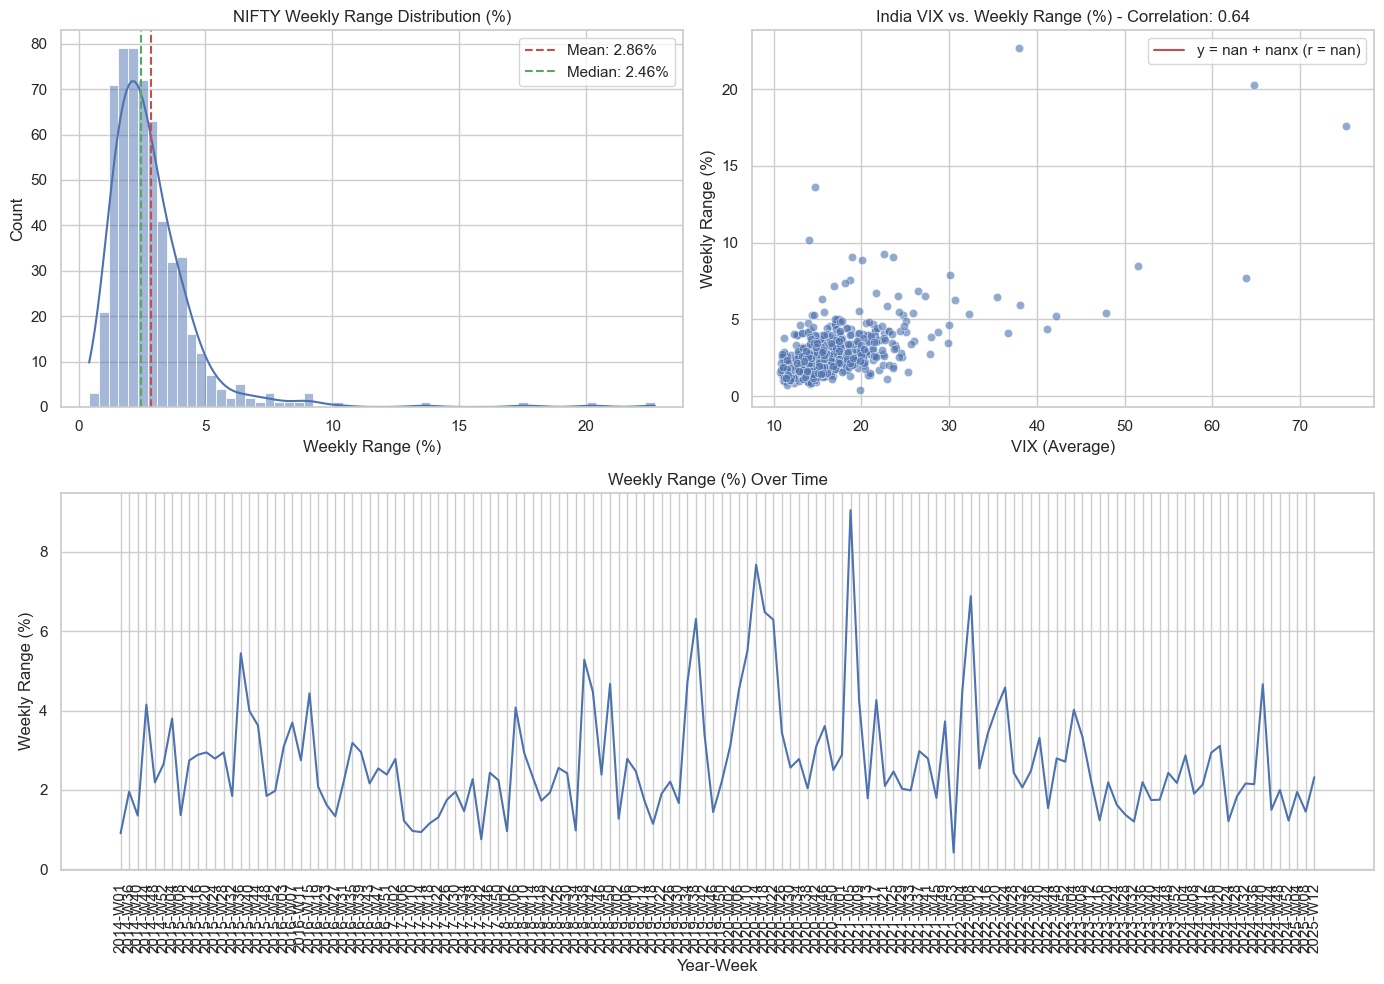


Weekly Range Analysis:
Average Weekly Range: 2.86%
Median Weekly Range: 2.46%
Correlation between VIX and Weekly Range: 0.6398
Linear Model: Weekly Range (%) = nan + nan * VIX

Percentiles of Weekly Range (%):
10th percentile: 1.36%
25th percentile: 1.82%
50th percentile: 2.46%
75th percentile: 3.41%
90th percentile: 4.40%
95th percentile: 5.41%
Preparing time series data for modeling...
Training data shape: (92137, 10), Test data shape: (121, 10)
Training period: 2014-09-09 10:00:00+05:30 to 2025-03-14 10:00:00+05:30
Testing period: 2025-03-14 11:00:00+05:30 to 2025-03-19 11:00:00+05:30
Finding optimal ARIMA parameters...


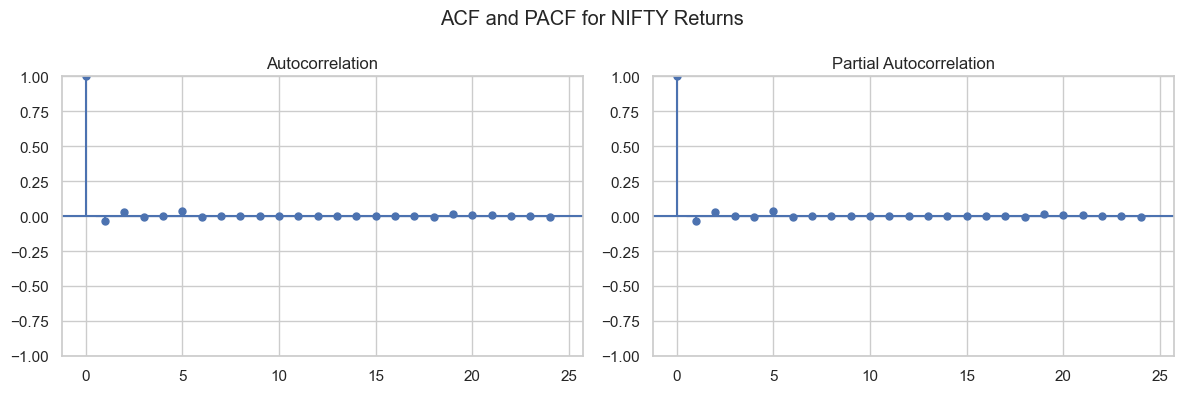

Evaluating 108 ARIMA models...
New best parameters found: ARIMA(0,0,0) with AIC=74453.23
New best parameters found: ARIMA(0,0,1) with AIC=-52554.81


KeyboardInterrupt: 

In [8]:
# Uncomment to run:
if __name__ == "__main__":
    main()